# Submitted by:
 
* Name 1: 
* Name 2:

## To be submitted by: 15.3.2019

# Polynomials Identification Project

This project identifies poynomials given in images. Specifically, polynomials of rank 3 are provided as RGB images to a neural netork, whose outputs are the coefficients of the given polynomials. The domain considered is "[0,1]x[0,1] box". PyTorch is the platform used.

### **You are given the following files:**
  Three directories named "train", "validation", and "test" each containing the following:
  1. a directory called "images" with RGB png files of size 128x128 (so image that is read has shape (3,128,128))
  2. a file "labels.txt" containing the coefficients of all images in "images" directory

Since this problem is a somewhat open ended, you are given a suggested structure and some functionality that is already implemented for you (see below). You are not at all obigated to follow this structure or use the code given. 

**Notes:** 
- When referring to a "polynomial", we either refer to an image or to the 4 coefficients. The meaning should be clear from context  
- "network" and "model" are used interchangeably throughout this documentation.
 
 
### **General structure (in order):**
 1. DataSet and DataLoader            - this is how you load data into the network **(given to you)**
 2. Seperable convolution class       - You can use this in your network class if you want **(given to you)**
 3. Neural Network definition         - the class that defines your model   **(NEED TO IMPLEMENT)**
 4. calculate model parameters number - useful to get a feel for network's size **(given to you)**
 5. estimate number of ops per forward feed - the bigger this is the slower the training **(given to you)**
 6. loss function definition          - to be used in training **(NEED TO IMPLEMENT)**
 7. create an optimizer               - choose your optimizer **(NEED TO IMPLEMENT)**
 8. estimate ops per forward feed     - use function given to you to estimate this **(implement for convenience)**
 9. view images and coefficients      - example code to help you see how to use loaders **(given to you)**
 10. validate_model                   - returns avg loss per image for a model and loader  **(NEED TO IMPLEMENT)**
 11. train_model                      - trains the network **(NEED TO IMPLEMENT)**
 12. plot train/validaion losses      - visualizing train and validation losses from training **(given to you)**
 13. save/load model                  - allows you to save and load model to disk for later use **(given to you)**
 14. visualizing polynomials          - overlaying net polynomials over actual polynomials **(given to you)**
 
 
### ** What you need to do **
You have 5 (and a half...) things to do:
 1. Create a PolyNet class, which is your network model. This is a key component. The output of your model should be 4 numbers that represent the coefficients of the input polynomial image fed into your network. You should keep in mind the number of parameters in your model. If there are too many, it may overfit (and take longer to run). If there are too few, it may not be able to learn the task needed. A typical structure would have convolutional layers first and fully connected at the end, thus reducing number of parameteres. Consider which activation function you want to use, and whether or not you wish to use batch normalization or dropout. Also, you may use seperable convolution or regular convolution or both. Maxpool layers are also possible. Be creative.
 
 2. Create a loss function. This is another key component as it defines what it means for two polynomials to be similar or not. Namely, two polynomials (represented by two sets of coefficients: ground truth ("labels") and network outputs ("outputs")), whose images look similar should have a smaller loss than two polynomials whose images look less simialr. Think about how you would quantify "closeness"/"similarity" of polynomials.

 3. Choose an optimizer. Look here for some ideas: https://pytorch.org/docs/master/optim.html
 
 4. (This is the "half" thing to do). For your conveinece you may want to use the function calc_ops() that is given to you to calculate an estimate of the number of operations that your network does per feed forward. To do this, you need to enter your own network structure. An example of an arbitrary network is privided to you.
 
 5. Create a validate_model function that assesses (tests) the performance of a model. It returns the average loss per image for a given loader. It can be run on any set of data (train, validation, or test). You may want to run this function on validation set (loader) from within the train function (see below) after each epoch so as to see how loss behaves on validation during the training process.
 
 6. Create a train_model function that trains model. This function updates the following parameteres: model, train_losses, and validation_losses. Model is updated simply by the training processes when optimzer.step() is called. The other two parameteres are lists that hold the average loss per image for the corresponding data (train or validation). After every epoch (i.e., iteration that goes over the entire train data), you should save into these lists the average loss per image for the corresponding data loader. These lists are useful in that you can plot them (functionality given to you) and observe how model behaves. Observe: this fucnton returs nothing, however, it updates parameteres by reference. Specifically, model is updated (trained), and so are train and validation losses values.
 
**Note:** You are given three sets of data: trian, validation, and test. It is recommended that test not be touched until the very end, and validation be used to get a sense of your network's performance. 

### ** Running on a GPU: **
It is not necessary to use a GPU for this project. However, if you choose to do so, you will gain a major speedup to your training, which will save you much time. The code given to you identifies the hardware used and will  automatically run on either a GPU or CPU. 

### ** Useful links: **
1. PyTorch master tutorial - VERY useful: https://pytorch.org/docs/master/nn.html
2. PyTorch optimizers: https://pytorch.org/docs/master/optim.html
3. A list of possible reasons why things go wrong: https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607#74de

### ** Final tips: **
Use the Internet! Things will not work first time. You will get strange error messages. Google them up. The web is  great resource for tackling problems ranging from python error messages, to things not doing what you'd like them to do.


### ** Submission Instructions**
The project is to be submittd in pairs. You need to submit the following three files:
1. model.dat                            - This is your saved model 
2. Polynomial_Identifier_Project.ipynb  - This is this notebook containing all of your work
3. model.py                             - A file containing your PolyNet class only. 

Before you submit, run "check_before_submission.ipynb" to make sure your model can be properly tested. See instructions for running this notebook inside.

Make sure your names appear at the top of this notebook in the appropriate place.

### **GOOD LUCK!**

In [2]:
import numpy as np
import PIL.Image as Image
from PIL import ImageDraw

import torch.nn as nn
from scipy import integrate as integrate
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import glob
import datetime

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache() 

# Dataset class definition (given to you) 

In [3]:
class PolyDataset(Dataset):
    
    def __init__(self, dataset_dir):
        """
        Initializing dataset by generating a dicitonary of labels, where an image file name is the key 
        and its labels are the contents of that entry in the dictionary. Images are not loaded. This way it
        is possible to iterate over arbitrarily large datasets (limited by labels dicitonary fitting 
        in memory, which is not a problem in practice)
        
        Args:
            dataset_dir : path to directory with images and labels. In this directory we expect to find
                          a directory called "images" containing the input images, and a file called 
                          "labels.txt" containing desired labels (coefficients)
        """
        
        self.dataset_dir = dataset_dir
        self.labels_dict = self.gen_labels_dict()
        self.images_keys = list(self.labels_dict)  # getting the keys of the dictionary as list
        self.images_keys.sort()                    # sorting so as to have in alphabetical order 

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, index):    
        """
        This funtion makes it possible to iterate over the PolyDataset
        Args:
            index: running index of images
            
        Returns:
            sample: a dicitionary with three entries:
                    1. 'image'  contains the image
                    2. 'labels' contains labels (coeffs) corresponding to image
                    3. 'fname'  contains name of file (image_key) - may be useful for debugging
        """
        image_key = self.images_keys[index]     # recall - key is the file name of the corresponding image
        image = np.array(Image.open(image_key)) # image has shape: (128, 128, 3)
        image = image/255.0                     # simple normalization - just to maintain small numbers
        image = np.transpose(image, (2, 0, 1))  # network needs RGB channels to be first index
        labels = self.labels_dict[image_key]
        sample = {'image': image, 'labels': labels, 'fname':image_key}
        
        return sample
    
    
    def gen_labels_dict(self):
        """
        This fucntion generates a dictionary of labels
        
        Returns:
            labels_dict: the key is image file name and an array of labels is the corresponding contents 
        """
        
        labels_fname = self.dataset_dir + "/labels.txt"
        labels_dict = {}
        with open(labels_fname, "r") as inp:
            for line in inp:
                line = line.split('\n')[0]                                      # remove '\n' from end of line 
                line = line.split(',')
                key  = self.dataset_dir + '/images/' + line[0].strip() + ".png" # image file name is the key
                del line[0]
                
                list_from_line = [float(item) for item in line]
                labels_dict[key] = np.asarray(list_from_line, dtype=np.float32)
                        
        return labels_dict             


# Create Data Loaders (given to you) 

In [4]:
train_dir      = "./train/"
validation_dir = "./validation/"
test_dir       = "./test/"


train_dataset = PolyDataset(train_dir)

train_loader = DataLoader(train_dataset, 
                          batch_size=16,
                          shuffle=True)



validation_dataset = PolyDataset(validation_dir)

validation_loader = DataLoader(validation_dataset, 
                               batch_size=1,
                               shuffle=True)



test_dataset = PolyDataset(test_dir)

test_loader = DataLoader(test_dataset, 
                          batch_size=1,
                          shuffle=False)
import matplotlib.pyplot as plt 
conaiter =  iter(train_loader).next()
#print(conaiter["image"].shape)
#print(conaiter["labels"])

print("train loader examples     : ~", len(train_loader)*train_loader.batch_size)
print("validation loader examples: ~", len(validation_loader)*validation_loader.batch_size)
print("test loader examples      : ~", len(test_loader)*test_loader.batch_size)

train loader examples     : ~ 1008
validation loader examples: ~ 100
test loader examples      : ~ 100


# Seperable convolution class (given to you)

In [5]:
class SeparableConv2d(nn.Module):
    """
    Seperable convolution - you can try it out if you want
    """
    def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,
                               in_channels,
                               kernel_size,
                               stride,
                               padding,
                               dilation,
                               groups=in_channels,
                               bias=bias)
        
        self.pointwise = nn.Conv2d(in_channels, 
                                   out_channels, 
                                   kernel_size=1,
                                   stride=1, 
                                   padding=0, 
                                   dilation=1, 
                                   groups=1, 
                                   bias=bias)

    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

# Neural Network class definition

In [6]:
in_features=30*15*15
out_features=4

class PolyNet(nn.Module):    # nn.Module is parent class
    def __init__(self,p=0.3):
        super(PolyNet, self).__init__()  # calls init of parent class
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                              out_channels=50,
                                              kernel_size=4,
                                              stride=2),
                                    nn.BatchNorm2d(50),
                                    nn.ReLU())
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=50, out_channels=40, kernel_size=4, stride=1),
                                    nn.BatchNorm2d(40),
                                    nn.ReLU())
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=40,
                                              out_channels=30,
                                              kernel_size=4,
                                              stride=4),
                                    nn.BatchNorm2d(30),
                                    nn.ReLU())                    

        self.fc = nn.Linear(in_features,out_features)
        # ----------------------------------------------
        # implementation needed here
        # ----------------------------------------------

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
#         out = self.layer2(out)
#         print(out.shape)
#         print(out.shape)
#         print(out.shape)

        """
        Feed forward through network
        Args:
            x - input to the network
            
        Returns "out", which is the network's output
        """

        # ----------------------------------------------
        # implementation needed here
        # ----------------------------------------------

        return out


# Get number of trainable parameters (given to you)  

In [7]:
def get_train_params_num(model):
    """
    This fucntion returns the number of trainable parameters of neural network model
    You may want to call it after you create your model to see how many parameteres the model has
    Args:
        model - neural net to examine. NOTE: this is an instantiation of the PolyNet class, not the class itself 
    """
    
    model_parameters = filter(lambda p: p.requires_grad==True, model.parameters())
    params_num = sum([np.prod(p.size()) for p in model_parameters])
    return params_num


# Get an estimate number of operations (given to you)

In [8]:
def calc_ops(inp_size, net_struct):
    """
    Calculates a rough number of operations for a given network topology
    Args:
        inp_size - (W,H) of input 
        net_struct - list of tuples describing structure of network. 
        
        Example:
         (('conv2d', (3, 8, 3, 1, 0)),  # cin, cout, kernel, stride, pad
          ('conv2d', (8, 8, 3, 1, 0)),
          ('MaxPool2d', (2,2)),         # kernel, stride
          ('fc', (64, 8)),      
          ('fc', (8, 4)))
         
    """
    
    ops = 0
    W, H = inp_size
    for curr_item in net_struct:
        if curr_item[0] == 'conv2d':
            cin = curr_item[1][0]
            cout = curr_item[1][1]
            kernel = curr_item[1][2]
            stride = curr_item[1][3]
            curr_ops = (W*H*cin*cout*kernel*kernel)/stride
            pad = curr_item[1][4]
            W = (W +2*pad - kernel)/stride + 1
            H = (H +2*pad - kernel)/stride + 1
            ops += curr_ops
            print (curr_item, ":",  "{:,}".format(int(curr_ops)))
        elif curr_item[0] == 'MaxPool2d':
            kernel = curr_item[1][0]
            stride = curr_item[1][1]
            W = (W - kernel)/stride + 1
            H = (H - kernel)/stride + 1
        else:
            curr_ops = curr_item[1][0] * curr_item[1][1]
            ops += curr_ops
            print (curr_item, ":",  "{:,}".format(int(curr_ops)))
            
    return int(ops)


# Loss function definition

In [9]:
def f(x,a,b,c,d):  #a is a parameter, x is the variable I want to integrate over
    return a*np.power(x, 3)+b*np.power(x, 2)+ c*x+d

def my_loss(outputs, labels,i):

    """
    Args:
        outputs - output of network ([batch size, polynomials rank + 1 (i.e., coefficients number)]) 
        labels  - desired coefficients  ([batch size, polynomials rank + 1 (i.e., coefficients number)])
    """
    
    loss = torch.zeros(1, dtype=torch.float, requires_grad=True)
    loss = loss.to(device)
#     loss = torch.sqrt(torch.mean((outputs-labels)**2))
#     loss = torch.sqrt(torch.mean(torch.abs(outputs-labels)))
#     return loss
    o= outputs.cpu().data.numpy()
    l= labels.cpu().data.numpy()
    polyList = o-l
    for inx,poly in enumerate(polyList):
        result = integrate.quad(f,0,1,args=(poly[0],poly[1],poly[2],poly[3]))
        loss = loss + abs(result[0])
#         print("the polynom is :",poly,"poly area is:",abs(result[0]),"part of block:",inx ,"of running loader chunck:",i,"loss is:",loss)
    
    
    
#     for poly in polyList:
#         p1 = np.poly1d(poly)
#         i1 = p1.integ()
#         area =  i1(1) - i1(0)
#         loss = loss + abs(area)        
   
      
#     polyList = np.array([o,l])
#     for i in range(polyList.shape[1]):
#         polys = polyList[:,i,:]
#         p1 = np.poly1d(polys[0])
#         i1 = p1.integ()
#         area1 =  i1(1) - i1(0)
        
#         p2 = np.poly1d(polys[1])
#         i2 = p2.integ()
#         area2 =  i2(1) - i2(0)
#         area = abs(area2 - area1)
#         loss = loss + area




 
    #----------------------------------------------
    # implementation needed here 
    #----------------------------------------------

    # Observe: If you need to iterate and add certain values to loss defined above
    # you cannot write: loss +=... because this will raise the error: 
    # "Leaf variable was used in an inplace operation"
    # Instead, to avoid this error write: loss = loss + ...  
    
                                      
    return loss


# Model creation and choice of optimizer

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

        
model = PolyNet().to(device)
model.apply(init_weights)
print ("Number of model trainable parameters:", get_train_params_num(model))

#----------------------------------------------
#  Choose your optimizer:
#  implementation needed here 
#----------------------------------------------
learning_rate = 0.01
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,nesterov=True,weight_decay=0.02)
optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate ,weight_decay=0.01, betas=(0.9, 0.999), eps=1e-08)


Number of model trainable parameters: 80964


# Check rough number of ops for network (for your convenience)

In [11]:
inp_size = (128,128)

example_net = (('conv2d', (3, 3, 3, 1, 1)),
               ('MaxPool2d', (2,2)),
               ('conv2d', (3, 3, 3, 1, 1)),
               ('MaxPool2d', (2,2)),
               ('fc', (2883, 4)))

### USE YOUR OWN NETWORK ####
              
ops = calc_ops(inp_size, example_net)
print()
print("Total ops: {:,}".format(ops))

('conv2d', (3, 3, 3, 1, 1)) : 1,327,104
('conv2d', (3, 3, 3, 1, 1)) : 331,776
('fc', (2883, 4)) : 11,532

Total ops: 1,670,412


# View images, target coefficiets and  network coefficients (given to you)

In [12]:
"""
View first image of a given number of batches assuming that model has been created. Currently, code lines assuming
model has been creatd, are commented out. Without a model, you can view target coefficients and the corresponding
images.
This is given to you so that you may see how loaders and model can be used. 
"""

loader = train_loader # choose from which loader to show images
bacthes_to_show = 2
with torch.no_grad():
    for i, data in enumerate(loader, 0): #0 means that counting starts at zero
        inputs = (data['image']).to(device)
        labels = (data['labels']).to(device)
  
        img_fnames = data['fname']
        #outputs = model(inputs.float())
        img = Image.open(img_fnames[0])
        
        print ("showing image: ", img_fnames[0])
        
        labels_np_arr = labels[0]   # using ".numpy()" to convert tensor to numpy array
        labels_str = [ float(("{0:.2f}".format(x))) for x in labels_np_arr]
        
        #outputs_np_arr = outputs[0] # using ".numpy()" to convert tensor to numpy array
        #outputs_str = [ float(("{0:.2f}".format(x))) for x in outputs_np_arr]
        print("Target coeffs :", labels_str )
        #print("network coeffs:", outputs_str)
        print()
        img.show()
        
        if (i+1) == bacthes_to_show:
            break
        
              

showing image:  ./train//images/0407.png
Target coeffs : [1.88, -3.67, 1.31, 0.55]

showing image:  ./train//images/0416.png
Target coeffs : [-2.0, 0.42, 1.46, 0.18]



# Validate model function

In [13]:
def validate_model(model, loader):
    """
    This function parses a given loader and returns the avergae (per image) loss (as defined by "my_loss" 
    of the entire dataset associated with the given loader.
    
    Args:
        model  - neural network to examine
        loader - where input data comes from (train, validation, or test)
        
    returns:
        average loss per image in variable named "avg_loss"
    """
    avg_loss = 0
    size = 0
    for i, data in enumerate(loader): #0 means that counting starts at zero
        image = (data['image']).to(device)
        labels = (data['labels']).to(device)
        # Forward pass
        outputs = model(image.float())
        loss = my_loss(outputs, labels,i)
        avg_loss = avg_loss + loss
        
    avg_loss = avg_loss / (len(loader)*loader.batch_size)
    return avg_loss


# train model function

In [14]:
def train_model(model,
                optimizer,
                train_loader,
                validation_loader,
                train_losses,
                validation_losses,
                epochs=1):
    
    """
    Trains a neural network. 
    Args;
        model               - model to be trained
        optimizer           - optimizer used for training
        train_loader        - loader from which data for training comes 
        validation_loader   - loader from which data for validation comes (maybe at the end, you use test_loader)
        train_losses        - adding train loss value after each epoch to this list for future analysis
        validation_losses   - adding validation loss value after each epoch to this list for future analysis
        epochs              - number of runs over the entire data set 
        
    No value is returned - model is updated during training 
    """
    total_step = len(train_loader)
    model.train()  #back to default
    for epoch in range(epochs):
        
        loss = validate_model(model,loader)
        train_losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 20== 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))
                
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        for epoch in range(epochs):
            loss = validate_model(model,validation_loader)
            validation_losses.append(loss)

   

# Actual train (given to you)

In [15]:
# Using two lists (train_losses, validation_losses) containing history of losses (i.e., loss for each 
# training epoch) for train and validation sets. If thess are not defined, we define them. Otherwise, the 
# function train_model updates these two lists (by adding loss values after each epoch when it is called for
# further training) in order to be able to visualize train and validation losses


if not 'train_losses' in vars():
    train_losses = []
if not 'validation_losses' in vars():
    validation_losses = []


train_model(model, 
            optimizer,
            train_loader, 
            validation_loader, 
            train_losses, 
            validation_losses,
            epochs=100)


Epoch [20/100], Step [2/63], Loss: 0.4722
Epoch [40/100], Step [2/63], Loss: 0.4721
Epoch [60/100], Step [2/63], Loss: 0.4717
Epoch [80/100], Step [2/63], Loss: 0.4718
Epoch [100/100], Step [2/63], Loss: 0.4710


# Plot losses from training process (given to you)

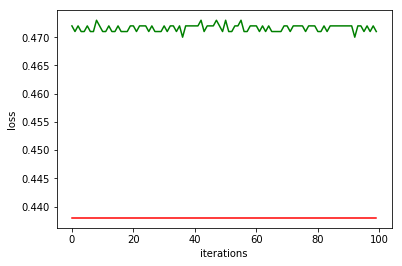

In [19]:
import matplotlib.pyplot as plt


iteration = np.arange(0., len(train_losses))
plt.plot(iteration, train_losses, 'g-', iteration, validation_losses, 'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()
    


# Save/Load Model (given to you)

In [20]:
def save(model, train_losses, validation_losses, save_dir):
    """
    saving model, train losses, and validation losses
    Args:
        model              - NN to be saved
        train_losses       - history of losses for training dataset
        validation_losses  - history of losses for validation dataset
        save_dir           - directory where to save the above
    """
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    torch.save(model, save_dir + "/model.dat")
    
    train_losses_f = open(save_dir + "/train_losses.txt", "wt")
    train_losses_f.writelines( "%.3f\n" % item for item in train_losses)
    
    validation_losses_f = open(save_dir + "/validation_losses.txt", "wt")
    validation_losses_f.writelines( "%.3f\n" % item for item in validation_losses)

    return
   

def load(save_dir):
    """
    loading model, train losses, and validation losses
    Args:
       save_dir  - dir name from where to load 
    """
    
    model = torch.load(save_dir + "/model.dat") 
    
    train_losses_f = open(save_dir + "/train_losses.txt", "rt")
    train_losses    = train_losses_f.readlines()
    train_losses   = [float(num) for num in train_losses]
    
    validation_losses_f = open(save_dir + "/validation_losses.txt", "rt")
    validation_losses   = validation_losses_f.readlines()
    validation_losses   = [float(num) for num in validation_losses]
    
    return (model, train_losses, validation_losses)
   

# Example saving and loading

In [21]:
# Create a directory "./saves/" where you place your saved models

save(model, train_losses, validation_losses, "./saves/try/")

model, train_losses, validation_losses = load("./saves/try/")

C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type PolyNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Draw target and net polynomials (given to you)

In [22]:
def gen_points_dict_for_all_images(model, loader): 
    """
    create a dictionary of dictionaries, where main key is file name of image.
    Each elemnts is then a dictionary of two items: 'pts_net', 'pts_tgt'
    each such item is a list of points of the form: [[x1,y1], [x2,y2],....]
    
    Args:
        model     - network for which polynimials are examined
        loader    - input data to use 
    """
    
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
                  # (dropout is set to zero)

    points_dict = {}  
        
    k=0
    print ("generating points_dict for all images:")
    
    for data in loader:
        # get inputs
        inputs = (data['image']).to(device)
        labels = (data['labels']).to(device)
        img_fnames = data['fname'] 
      
        
        # forward
        outputs = model(inputs.float())
        curr_batch_size = np.shape(outputs)[0]
        coeffs_num = np.shape(labels)[1]  # labels shape is (batch_size, coeffs_num)
        image_size = np.shape(inputs[0])  # image_size = [3, w, h]
        _, width, height = image_size
        
        for i in range (curr_batch_size): 
            coeffs_net = [] 
            coeffs_tgt = []
            for curr_coeff in range(coeffs_num):
                coeffs_net.append(outputs[i, curr_coeff].item()) 
                coeffs_tgt.append(labels[i, curr_coeff].item())
                

            poly_net = np.poly1d(coeffs_net) # generate polynomial representation
            poly_tgt = np.poly1d(coeffs_tgt) # generate polynomial representation

    
            x_pts = np.arange(0.0, 1.0, 0.01/width)
            y_pts_net = poly_net(x_pts)  # execute net polynomial on x_pts
            y_pts_tgt = poly_tgt(x_pts)  # execute tgt polynomial on x_pts
            
            y_pts_net = 1 - y_pts_net  # b/c on screen y=0 is on top, now 0 is at bottom as we are used
            y_pts_tgt = 1 - y_pts_tgt  # b/c on screen y=0 is on top, now 0 is at bottom as we are used
    
            x_pts *= width
            y_pts_net *= height
            y_pts_tgt *= height
    
            
            pts_net = [list(a) for a in  zip(x_pts, y_pts_net)]
            pts_tgt = [list(a) for a in  zip(x_pts, y_pts_tgt)]

            input_fname = img_fnames[i] 
            k+=1
            print (str(k) + ".   " + input_fname)
            points_dict[input_fname] = {'pts_net': pts_net,
                                        'pts_tgt': pts_tgt} 
   
    model.train()  #back to default           
    return points_dict


def draw_poly(points_dict, out_dir):
    """
    Draws polynomials from given dictionary of dictionaries 
    
    Args:
        points_dict - dictionary. key is file name of frame (fname) and elemet is a dictionary with
                       keys: 'pts_net', 'pts_tgt'. Each of which has a list of points:(x,y)
        out_dir     - ouptut directory name (e.g.: 'draws/')
    """
    
       
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    files = glob.glob(out_dir + '*.png')
    for f in files:
        os.remove(f) 


    print("Marking frames:")
    index = 1
    for fname in points_dict:
        orig_img = Image.open(fname)
        img = Image.new(orig_img.mode, orig_img.size, (255, 255, 255))
        
        fname_points_list_net = points_dict[fname]['pts_net']
        fname_points_list_tgt = points_dict[fname]['pts_tgt']

        fname_points_list_net = [(point[0], point[1]) for point in fname_points_list_net]
        fname_points_list_tgt = [(point[0], point[1]) for point in fname_points_list_tgt]
        draw = ImageDraw.Draw(img)
        draw.point(fname_points_list_net, (255, 0, 0, 255))  # net: red
        draw.point(fname_points_list_tgt, (0, 255, 0, 255))  # tgt: green
        
    
        img.save(out_dir + fname.split('/')[-1])
        
        print (index, out_dir + fname.split('/')[-1])
        index+=1
        
        
def draw_loader_polynomials(model, loader, out_dir):
    """
    This fucntion receives a model and a loader and for each polymonial image in the loader it draws
    the polynomial that it identifies. Both polynomials (the original (in green) and the network's (in red)) 
    are saved as an image in the given out_dir diretory.
    Args:
        model   - network for which polynimials are drawn
        loader  - input data to use 
        out_dir - ouptut directory name (e.g.: 'draws/')   
    """
    
    points_dict = gen_points_dict_for_all_images(model, loader)  
    draw_poly(points_dict, out_dir)
    return

# Example of how to draw target and net polynomials 

In [23]:
# Drawing polynomials from validation loader and placing them in directory "./validation/draw/"
# The green colored polynomials are the desired outputs and the red polynomials are network's 
# actual outputs. Notice that if in an image you see no red polynomial, it means it is not inside the 
# [0,1]x[0,1] "box", which is the domain considered.  This means that your model has siginificant error

draw_loader_polynomials(model, validation_loader, './validation/draw/')


generating points_dict for all images:
1.   ./validation//images/0031.png
2.   ./validation//images/0003.png
3.   ./validation//images/0070.png
4.   ./validation//images/0043.png
5.   ./validation//images/0094.png
6.   ./validation//images/0040.png
7.   ./validation//images/0021.png
8.   ./validation//images/0082.png
9.   ./validation//images/0017.png
10.   ./validation//images/0099.png
11.   ./validation//images/0058.png
12.   ./validation//images/0032.png
13.   ./validation//images/0085.png
14.   ./validation//images/0020.png
15.   ./validation//images/0047.png
16.   ./validation//images/0081.png
17.   ./validation//images/0009.png
18.   ./validation//images/0079.png
19.   ./validation//images/0026.png
20.   ./validation//images/0069.png
21.   ./validation//images/0025.png
22.   ./validation//images/0029.png
23.   ./validation//images/0014.png
24.   ./validation//images/0042.png
25.   ./validation//images/0076.png
26.   ./validation//images/0097.png
27.   ./validation//images/0008.pn